# Simple state space model for 2pp voting intention

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Load-2pp-data-and-prepare-for-analysis" data-toc-modified-id="Load-2pp-data-and-prepare-for-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load 2pp data and prepare for analysis</a></span></li><li><span><a href="#The-model" data-toc-modified-id="The-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The model</a></span></li><li><span><a href="#Diagnostics" data-toc-modified-id="Diagnostics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Diagnostics</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#2pp-Voting-Intention" data-toc-modified-id="2pp-Voting-Intention-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>2pp Voting Intention</a></span></li><li><span><a href="#House-effects" data-toc-modified-id="House-effects-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>House effects</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP
print(f'Stan version: {stan.__version__}')
print(f'ArviZ version: {az.__version__}')

# system imports
import pathlib

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER

Stan version: 3.3.0
ArviZ version: 0.11.4


In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# path to the model data
DATA_DIR = '../data'
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
DATA_DIR += '/'

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
s_args = {'lfooter': 'Polling data from Wikipedia'}
MODEL_NAME = 'Bayesian State Space Model'

## Load 2pp data and prepare for analysis

In [5]:
# read in 2pp data; remind me, what are the column names ...
tpp = pd.read_csv(f'{DATA_DIR}two_party_preferred.csv', parse_dates=['Mean Date'], index_col=0)
tpp.columns

Index(['2pp vote L/NP', '2pp vote ALP', 'Date', 'Mean Date', 'Brand',
       'Interview mode', 'Sample size', '2pp Vote L/NP LOWESS'],
      dtype='object')

In [6]:
# What polling firms are we working with ...
# and how many polls has each collected
tpp['Brand'].value_counts()

Newspoll-YouGov    38
Essential          38
Roy Morgan         19
Name: Brand, dtype: int64

In [7]:
# Encode polling firms to an integer starting from 1
tpp['Brand'] = tpp['Brand'].astype('category')
tpp['House'] = tpp['Brand'].cat.codes + 1
tpp['House'].value_counts()

2    38
1    38
3    19
Name: House, dtype: int64

In [8]:
# Create a map of firm number back to firm name
# Not the most efficient way to do this ...
brand_map = {x+1: y for x, y in zip(tpp['Brand'].cat.codes, tpp['Brand'])}
brand_map

{2: 'Newspoll-YouGov', 3: 'Roy Morgan', 1: 'Essential'}

In [9]:
# Change dates to days from the start ...
# The first day is 1
first_day = tpp['Mean Date'].min()
tpp['Day'] = (
    ((tpp['Mean Date'] - first_day) 
     / pd.Timedelta(days=1)).astype(int) 
    + 1
)

# Total number of days to model ...
tpp['Day'].max()

846

In [10]:
# Number of polls
len(tpp)

95

## The model

This implements a Gaussian state space model. The model has a number of parts:
* a hidden state model of (day-to-day) population two-party preferred (2pp) voting intention for a political party (i.e. the voting intention on any day is normally distributed around the voting intention on the previous day), 
* a periodic measurement model in the form of opinion poll data (assuming polling firms produce results that are normally distributed around a systemic house bias, and that the house bias across all polling firms sums to zero)
* prior assumptions: that the population-wide voting intention on day one will be broadly distributed around 50 per cent, and that the house effects for each polling firm will be broadly distributed around zero. 

The model takes some simplification liberties. For example, it assumes that all opinion polls have a sample size of 1000 respondents. 

Note: the model works with the data in integer percentage points. The data is first transformed by subtracting 50 percentage points before being made available to the model. This means that (with the Australian data and political context) the model will most likely be operating in the range of -10 to plus 10, and typically much closer to zero. 

In [11]:
sampleSize = 1000 # treat all polls as being of this size
pseudoSampleSigma = np.sqrt((50 * 50) / sampleSize) 

tpp_model_data = {
    # Note: parameterised to have the 2pp in the unit scale around zero.
    #       i.e. whole 2pp percentage points - 50.

    # Reminder: Stan numbers arrays from 1 to N
    # Note: JSON cannot serialise pandas or numpy datatypes
    
    'n_polls': len(tpp),
    'n_days': int(tpp['Day'].max()),
    'n_houses': int(tpp['House'].max()),

    'pseudoSampleSigma': pseudoSampleSigma,
    
    'y': (tpp['2pp vote L/NP'] - 50).to_list(),
    'house': tpp['House'].to_list(),
    'day': tpp['Day'].to_list(),
}


In [12]:
tpp_model_code = """

// STAN: Two-Party Preferred (TPP) Vote Intention Model 

data {
    // data size
    int<lower=1> n_polls;
    int<lower=1> n_days;
    int<lower=1> n_houses;
    
    // assumed standard deviation for all polls
    real<lower=0> pseudoSampleSigma;
    
    // poll data
    vector<lower=-50,upper=50>[n_polls] y; // TPP vote share
    int<lower=1> house[n_polls];
    int<lower=1> day[n_polls];
}

transformed data {
    real sigma = 0.15; // day-to-day std deviation in percentage points 
}

parameters {
    vector[n_days] hidden_vote_share; 
    vector[n_houses] pHouseEffects;
}

transformed parameters {
    // -- sum to zero constraint on house effects
    vector[n_houses] houseEffect;
    houseEffect[1:n_houses] = pHouseEffects[1:n_houses] - mean(pHouseEffects[1:n_houses]);
}

model {
    // -- temporal model [this is the hidden state space model]
    hidden_vote_share[1] ~ cauchy(0, 10); // PRIOR (reasonably uninformative)
    hidden_vote_share[2:n_days] ~ normal(hidden_vote_share[1:(n_days-1)], sigma);
    
    // -- house effects model
    pHouseEffects ~ normal(0, 8); // PRIOR (reasonably uninformative)

    // -- observed data / measurement model
    y ~ normal(houseEffect[house] + hidden_vote_share[day], pseudoSampleSigma);
}

"""

In [13]:
posterior = stan.build(tpp_model_code, data=tpp_model_data)

Building: found in cache, done.
Messages from stanc:


In [14]:
# this step typically takes around 3 minutes
fit = posterior.sample(num_chains=4, num_samples=2500)

Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   0% (4/14000)
Sampling:   1% (103/14000)
Sampling:   1% (202/14000)
Sampling:   2% (301/14000)
Sampling:   3% (400/14000)
Sampling:   4% (500/14000)
Sampling:   4% (600/14000)
Sampling:   5% (700/14000)
Sampling:   6% (800/14000)
Sampling:   6% (900/14000)
Sampling:   7% (1000/14000)
Sampling:   8% (1100/14000)
Sampling:   9% (1200/14000)
Sampling:   9% (1300/14000)
Sampling:  10% (1400/14000)
Sampling:  11% (1500/14000)
Sampling:  11% (1600/14000)
Sampling:  12% (1700/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (1900/14000)
Sampling:  14% (2000/14000)
Sampling:  15% (2100/14000)
Sampling:  16% (2200/14000)
Sampling:  16% (2300/14000)
Sampling:  17% (2400/14000)
Sampling:  18% (2500/14000)
Sampling:  19% (2600/14000)
Sampling:  19% (2700/14000)
Sampling:  20% (2800/14000)
Sampling:  21% (2900/14000)
Sampling:  21% (3000/14000)
Sampling:  22% (3100/14000)
Sampling:  23% (3200/14000

## Diagnostics

In [15]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hidden_vote_share[0],1.583,0.976,-0.302,3.366,0.011,0.008,7808.0,8134.0,1.0
hidden_vote_share[1],1.571,0.971,-0.270,3.363,0.011,0.008,7789.0,8186.0,1.0
hidden_vote_share[2],1.558,0.970,-0.334,3.309,0.011,0.008,7559.0,8556.0,1.0
hidden_vote_share[3],1.549,0.967,-0.238,3.416,0.011,0.008,7639.0,8323.0,1.0
hidden_vote_share[4],1.539,0.963,-0.242,3.383,0.011,0.008,7422.0,7787.0,1.0
...,...,...,...,...,...,...,...,...,...
pHouseEffects[1],0.078,4.713,-8.767,8.873,0.045,0.058,11103.0,5501.0,1.0
pHouseEffects[2],-0.153,4.713,-8.920,8.775,0.045,0.058,11157.0,5655.0,1.0
houseEffect[0],0.219,0.244,-0.267,0.653,0.003,0.002,8274.0,7513.0,1.0
houseEffect[1],0.006,0.262,-0.475,0.506,0.003,0.002,7174.0,7279.0,1.0


In [16]:
# Estimated Bayesian Fraction of Missing Information ...
# Good if close to one; bad if close to zero ...
bfmi = az.bfmi(fit)
if (bfmi <= 0.5).any():
    print('Note: the BFMI could be problematic')
    print(bfmi)

In [17]:
# R-hat chain convergence diagnostic
# ESS - effective sample size (used to be n_eff)
RHAT_THRESHOLD = 1.05
ESS_THRESHOLD = 1000
rhat = az.rhat(fit)
ess = az.ess(fit)
for var in ['houseEffect', 'hidden_vote_share']:
    if (rhat[var] > RHAT_THRESHOLD).any():
        print(f'Check {var} - chain convergence')
    if (ess[var] < ESS_THRESHOLD).any():
        print(f'Check {var} - effective sample size')

array([[<AxesSubplot:title={'center':'houseEffect'}>,
        <AxesSubplot:title={'center':'houseEffect'}>]], dtype=object)

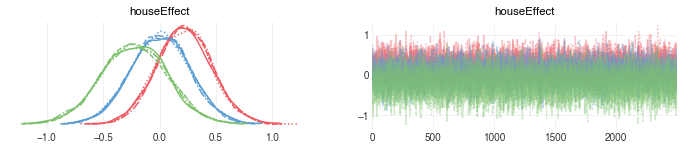

In [18]:
az.plot_trace(fit, var_names=['houseEffect'])

## Results

In [19]:
results_df = fit.to_frame()

In [20]:
quants = [0.005, 0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975, 0.995]
LOW = 'low'
HIGH = 'high'
ranges = pd.DataFrame({
    '99%': (0.005, 0.995),
    '95%': (0.025, 0.975),
    '80%': (0.100, 0.900),
    '50%': (0.250, 0.750),
}, index=[LOW, HIGH]).T
ranges

,low,high
99%,0.005,0.995
95%,0.025,0.975
80%,0.100,0.900
50%,0.250,0.750


### 2pp Voting Intention

In [21]:
# Get the daily hidden vote share data
hvs = (
    results_df[
        results_df.columns[
            results_df.columns.str.contains('hidden_vote_share')
        ]
    ]
)
hvs = hvs + 50 # percent
hvs.columns = pd.date_range(start=first_day, freq='D', 
                            periods=len(hvs.columns))
hvs = hvs.quantile(quants)

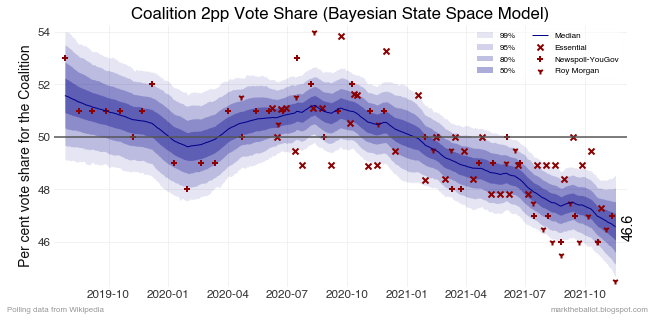

In [22]:
# Plot the daily hidden vote share data
fig, ax = common.initiate_plot()
alpha = 0.1
for x, y in ranges.iterrows():
    low = y[0]
    high = y[1]
    lowpoint = hvs.loc[low]
    highpoint = hvs.loc[high]
    ax.fill_between(x=lowpoint.index, y1=lowpoint, y2=highpoint,
                    color=COLOR_COALITION, alpha = alpha,label=x,)
    alpha += 0.075
    
ax.plot(hvs.columns, hvs.loc[0.500], 
        color=COLOR_COALITION, lw=1, label='Median')

# annotate end-point median to one devimal place ...
ax.text(hvs.columns[-1] + pd.Timedelta(days=10), 
        hvs.loc[0.500][-1], 
        f'{hvs.loc[0.500].round(1)[-1]}',
        rotation=90, ha='left', va='center',
        fontsize=14)

ax.axhline(y=50, c='#555555', lw=1.5)

brand_col = 'Brand'
markers = ['x', '+', '1', '2', '3', '4']
for i, brand in enumerate(sorted(tpp[brand_col].unique())):
    subset = tpp.loc[tpp[brand_col] == brand]
    if not len(subset):
        continue # ignore empty subsets
    ax.scatter(subset['Mean Date'], subset['2pp vote L/NP'], 
               marker=markers[i], label=brand,
               color='darkred')

ax.legend(loc='best', ncol=2)
    
common.plot_finalise(ax, 
                     title=f'Coalition 2pp Vote Share ({MODEL_NAME})',
                     ylabel='Per cent vote share for the Coalition',
                     **s_args,
                    )

### House effects

In [23]:
# Get the house effects data
house_effects = results_df[results_df.columns[results_df.columns.str.contains('houseEffect')]]
house_effects = house_effects  # percent
house_effects.columns = (
    house_effects.columns
    .str.extract(r'([\d]+)$')
    .pipe(lambda x: x[x.columns[0]])
    .astype(int)
    .map(brand_map)
)
house_effects = house_effects.quantile(quants)

0
Essential          0.217587
Newspoll-YouGov    0.007612
Roy Morgan        -0.224590
Name: 0.5, dtype: float64


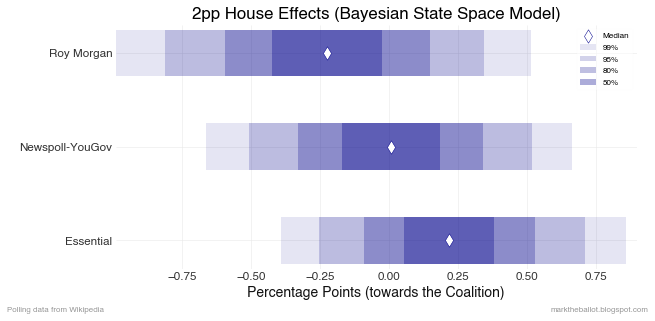

In [24]:
# Plot the house effects data
fig, ax = common.initiate_plot()

for i, house in enumerate(house_effects.columns):
    alpha = 0.1
    for x, y in ranges.iterrows():
        low = y[0]
        high = y[1]
        lowpoint = house_effects.loc[low, house]
        width = house_effects.loc[high, house] - lowpoint
        label = x if i == 0 else None
        ax.barh(y=house, left=lowpoint, width=width, 
                height=0.5, color=COLOR_COALITION, alpha=alpha,
                label=label)
        alpha += 0.075

ax.scatter(y=range(len(house_effects.columns)), 
           x=house_effects.loc[0.500],
           marker='d', facecolor='white',
           edgecolor=COLOR_COALITION, 
           linewidth=0.5, zorder=2,
           label='Median', s=90)

print(house_effects.loc[0.500])
ax.legend(loc='best')

common.plot_finalise(ax, 
                     title=f'2pp House Effects ({MODEL_NAME})',
                     xlabel='Percentage Points (towards the Coalition)',
                     **s_args, )
